# Entrenamiento de clasificador de semáforo con MobileNetV2

In [6]:
# Paso 1: Instalar dependencias
!pip install -q tensorflow onnx tf2onnx

# Paso 2: Importar librerías necesarias
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import shutil
import zipfile

# Paso 3: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paso 4: Copiar el ZIP desde Drive a Colab (cuida bien la ruta con tildes y espacios)
!cp "/content/drive/MyDrive/6° Semestre/Implementación de robótica inteligente/Reto/Reto Manchester/Final Challange/CNN/TrafficLightImages.zip" .

# Paso 5: Descomprimir el ZIP
with zipfile.ZipFile("TrafficLightImages.zip", 'r') as zip_ref:
    zip_ref.extractall("TrafficLightImages")

print("✔ Dataset descomprimido correctamente.")

# Paso 6 (opcional): Mostrar carpetas para verificar que todo está bien
print("Contenido de la carpeta TrafficLightImages:")
print(os.listdir("TrafficLightImages"))

# Corregimos la ruta del dataset real (subcarpeta dentro del ZIP)
DATASET_DST = "/content/TrafficLightImages/TrafficLightImages"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Dataset descomprimido correctamente.
Contenido de la carpeta TrafficLightImages:
['TrafficLightImages']


# Configurar el generador de datos y cargar imágenes

In [7]:
# Redimensionamos las imágenes a 160x120 como tu resolución original
IMG_SIZE = (120, 160)
BATCH_SIZE = 16

# Generador de datos (con aumento de datos)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% para entrenamiento, 20% para validación
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1
)

train_gen = datagen.flow_from_directory(
    DATASET_DST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATASET_DST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_gen.class_indices.keys())
print("Clases:", class_names)

Found 324 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Clases: ['green', 'off', 'red', 'yellow']


# Construir modelo MobileNetV2

In [8]:
# Cargar modelo base sin la parte final
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 160, 3))
base_model.trainable = False  # Congelamos pesos

# Añadir capa de clasificación final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-8-cf4b398bc22e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 160, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 60, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 60, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 60, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 60, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 60, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 60, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 60, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 60, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 60, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 60, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 60, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 61, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 30, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 30, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 30, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 30, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,228 (8.93 MB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Entrenar el modelo

In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 481ms/step - accuracy: 0.6375 - loss: 1.0847 - val_accuracy: 0.8375 - val_loss: 0.4470
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.9294 - loss: 0.2098 - val_accuracy: 0.8625 - val_loss: 0.4195
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.9880 - loss: 0.0746 - val_accuracy: 0.9250 - val_loss: 0.1813
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.9956 - loss: 0.0359 - val_accuracy: 0.9125 - val_loss: 0.2537
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.9957 - loss: 0.0177 - val_accuracy: 0.9250 - val_loss: 0.2767
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.9875 - val_loss: 0.0784
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.9927 - loss: 0.0318 - val_accuracy: 0.9500 - val_loss: 0.1649
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.9933 - loss: 0.0392 - val_accuracy: 

# Evaluar rendimiento

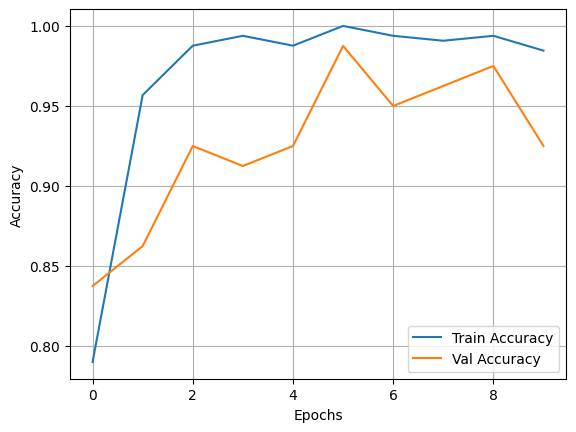

In [10]:
# Graficar precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Exportar a .keras

In [17]:
model.save("traffic_light_model.keras")
print("✔ Modelo guardado como .keras")

✔ Modelo guardado como .keras


In [18]:
from google.colab import files
files.download("traffic_light_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>